In [1]:
import os

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo)

In [2]:
def simulate(datapoint):
    # Defining topology
    my_chain = Chain(N_qubits=datapoint['N'])
    my_chain.set_initialization_strategy(strategy=datapoint['init_strat'])
    
    # Deciding between grid and 1d chain topology
    my_topology = my_chain
    
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=datapoint['N'], seed=datapoint['seed'])
    
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=datapoint['N'],
                                                                k=datapoint['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=datapoint['alpha'])
    
    portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    #full_space_max_cost = full_result['c_max']
    portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=datapoint['alpha'],
                         lmbda=lmbda+1e-8, # Adding small constant purposely
                         k=datapoint['k'])
    QUBO_limits = qubo_limits(Q=Q,offset=offset)
    qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
    qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=datapoint['alpha'], k=datapoint['k'])
    qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])

    
    if not portfolio_subspace_min_state_str == qubo_min_state_str:
        raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
        raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not qubo_max_cost >= portfolio_subspace_max_cost:
        raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')

    
    # Generating instances of ansatz'
    CP_z_phase_ansatz = CP_QAOA(N_qubits=datapoint['N'],
                     cardinality=datapoint['k'],
                     layers=datapoint['layers'],
                     topology=my_topology,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=datapoint['w_nnn'],
                     with_gradient=True,
                     approximate_hamiltonian=True,
                     with_z_phase=datapoint['w_z_phase'])
    
    NORMAL_ansatz = QAOA(N_qubits=datapoint['N'],
                     layers=datapoint['layers'],
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     constraining_mixer=False,
                     Topology=my_topology)
    
    # Choosing optimizer for scipy
    available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
    optimizer_method = available_methods[0]
    
    # Generating callback function for plotting
    CP_z_phase_costs = [] # Normalized costs
    CP_z_phase_probs = [] # probability of optimal state
    def CP_z_phase_callback_function(x):
        _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_z_phase_probs.append(0)
        CP_z_phase_costs.append(_cost_)
        
    # Generating callback function for plotting
    NORMAL_costs = [] # Normalized costs
    NORMAL_probs = [] # probability of optimal state
    def NORMAL_callback_function(x):
        _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            NORMAL_probs.append(0)
        NORMAL_costs.append(_cost_)
    
    # Generating initial guess for rotation angles
    np.random.seed(datapoint['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = datapoint['layers'] * len(my_topology.get_NN_indices())
    if datapoint['w_nnn']:
        N_angles = datapoint['layers'] * len(my_topology.get_NNN_indices())
    if datapoint['w_z_phase']:
        N_angles += datapoint['N'] * datapoint['layers']
    CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    np.random.seed(datapoint['seed'])
    N_angles = 2 * datapoint['layers']
    NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': datapoint['max_iter']},
                                      callback=CP_z_phase_callback_function)
    
    NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, 
                                      x0=NORMAL_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': datapoint['max_iter']},
                                      callback=NORMAL_callback_function)

    return {'N': datapoint['N'],
            'k': datapoint['k'],
            'alpha': datapoint['alpha'],
            'max_iter': datapoint['max_iter'],
            'topology': my_topology,
            'seed': datapoint['seed'],
            'next nearest neighbor': datapoint['w_nnn'],
            'layers': datapoint['layers'],
            'z-phase': datapoint['w_z_phase'],
            'QAOA': (NORMAL_probs,NORMAL_costs,NORMAL_res),
            'CP_VQA': (CP_z_phase_probs, CP_z_phase_costs, CP_z_phase_res)}

In [3]:
# Number of Qubits 
N_vals = [3,4,5,6,7,8,9,10]
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=1500
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True
# Number of layer repetitions
layer_dict = {3:1,
              4:1,
              5:2,
              6:2,
              7:2,
              8:2,
              9:2,
              10:2}


initialization_strategies = {3:np.array([0,1,0]),
                             4:np.array([0,1,0,1]),
                             5:np.array([0,1,0,1,0]),
                             6:np.array([0,1,0,1,0,1]),
                             7:np.array([0,1,0,1,0,1,0]),
                             8:np.array([0,1,0,1,0,1,0,1]),
                             9:np.array([0,1,0,1,0,1,0,1,0]),
                             10:np.array([0,1,0,1,0,1,0,1,0,1]),}


N_SEEDS = 7*50
N_jobs = os.cpu_count()-1

datapoints = []
for N in N_vals:
    for seed in range(N_SEEDS):
        k = N // 2
        N_layers = layer_dict[N]
        dp = {'N': N, 'k': k, 'alpha': alpha, 'max_iter': max_iter, 'seed': seed+1000, 'w_nnn': w_next_nearest_neighbors, 
              'layers': N_layers, 'w_z_phase': False, 'init_strat': initialization_strategies[N]}
        datapoints.append(dp)
        
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints)


# Initialize the largest index number
max_idx = -1

for idx, result in enumerate(r):
    # Generate the initial filename
    filename = f'fig_10_results/res_{idx}.pkl'

    # Check if this file already exists
    if os.path.exists(filename):
        # If the file exists, check if the index is larger than the maximum encountered so far
        max_idx = max(max_idx, idx)
        
        # Find the next available index
        new_idx = max_idx + 1
        while os.path.exists(f'fig_10_results/res_{new_idx}.pkl'):
            new_idx += 1
        
        # Update the filename and max_idx
        filename = f'fig_10_results/res_{new_idx}.pkl'
        max_idx = new_idx

    # Write to the file
    with open(filename, 'wb') as file:
        pickle.dump(result, file)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    4.8s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    5.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    5.1s
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(

In [4]:
results = []
for filename in os.listdir('fig_10_results'):
    if filename != '.DS_Store':
        with open('fig_10_results/'+filename, 'rb') as file:
            results.append(pickle.load(file))

In [5]:
results[1000]['N']

5

In [6]:
QAOA_probs, QAOA_costs = {f'N={N}':[] for N in N_vals}, {f'N={N}':[] for N in N_vals}
CP_VQA_probs, CP_VQA_costs = {f'N={N}':[] for N in N_vals}, {f'N={N}':[] for N in N_vals}
for result in results:
    _N_ = result['N']
    p_qaoa, c_qaoa, res_qaoa = result['QAOA']
    QAOA_probs[f'N={_N_}'].append(np.max(p_qaoa))
    QAOA_costs[f'N={_N_}'].append(np.min(c_qaoa))
    
    p_cp_vqa, c_cp_vqa, res_cp_vqa = result['CP_VQA']
    CP_VQA_probs[f'N={_N_}'].append(np.max(p_cp_vqa))
    CP_VQA_costs[f'N={_N_}'].append(np.min(c_cp_vqa))

for N in N_vals:
    mu, std = np.mean(QAOA_probs[f'N={N}']), np.std(QAOA_probs[f'N={N}'])
    QAOA_probs[f'N={N}'] = mu, std
    
    mu, std = np.mean(QAOA_costs[f'N={N}']), np.std(QAOA_costs[f'N={N}'])
    QAOA_costs[f'N={N}'] = mu, std
    
    mu, std = np.mean(CP_VQA_probs[f'N={N}']), np.std(CP_VQA_probs[f'N={N}'])
    CP_VQA_probs[f'N={N}'] = mu, std
    
    mu, std = np.mean(CP_VQA_costs[f'N={N}']), np.std(CP_VQA_costs[f'N={N}'])
    CP_VQA_costs[f'N={N}'] = mu, std

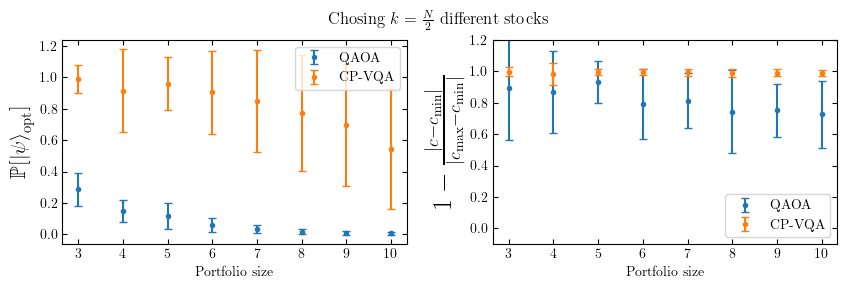

In [7]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Chosing '+r'$k=\frac{N}{2}$'+' different stocks')
fig.subplots_adjust(bottom=0.2,wspace=0.25)
ax[0].errorbar(N_vals, [QAOA_probs[f'N={N}'][0] for N in N_vals], yerr=[QAOA_probs[f'N={N}'][1] for N in N_vals], fmt='.', capsize=3,label='QAOA', )
ax[0].errorbar(N_vals, [CP_VQA_probs[f'N={N}'][0] for N in N_vals], yerr=[CP_VQA_probs[f'N={N}'][1] for N in N_vals], fmt='.', capsize=3, label='CP-VQA')
ax[0].legend(loc='upper right')
ax[0].set_xticks(N_vals)
ax[0].set_xlabel('Portfolio size')
ax[0].set_ylabel(r'$\mathbb{P}[\ket{\psi}_{\text{opt}}]$',fontsize=15)

ax[1].errorbar(N_vals, [1-QAOA_costs[f'N={N}'][0] for N in N_vals], yerr=[QAOA_costs[f'N={N}'][1] for N in N_vals], fmt='.', capsize=3,label='QAOA', )
ax[1].errorbar(N_vals, [1-CP_VQA_costs[f'N={N}'][0] for N in N_vals], yerr=[CP_VQA_costs[f'N={N}'][1] for N in N_vals], fmt='.', capsize=3, label='CP-VQA')
ax[1].legend(loc='lower right')
ax[1].set_xticks(N_vals)
ax[1].set_ylim(-0.1,1.2)
ax[1].set_xlabel('Portfolio size')
ax[1].set_ylabel(r'$1-\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', fontsize=19)
#plt.savefig('fig_8.png', dpi=300)
plt.show()